# Retrieving dataset

In [3]:
!gdown 16xIx6UoSU6D1K6Q6jtIh8zo_BP2ALCs- #https://drive.google.com/file/d/16xIx6UoSU6D1K6Q6jtIh8zo_BP2ALCs-/view?usp=sharing
!unzip -q /content/dataset

usage: gdown [-h] [-V] [-O OUTPUT] [-q] [--fuzzy] [--id] [--proxy PROXY]
             [--speed SPEED] [--no-cookies] [--no-check-certificate]
             [--continue] [--folder] [--remaining-ok] [--format FORMAT]
             [--user-agent USER_AGENT]
             url_or_id
gdown: error: unrecognized arguments: #https://drive.google.com/file/d/16xIx6UoSU6D1K6Q6jtIh8zo_BP2ALCs-/view?usp=sharing
'unzip' is not recognized as an internal or external command,
operable program or batch file.


# Import necessary Libraries

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Check dataset

In [6]:
customer_info = pd.read_csv(r'D:\KKU_World\Learn\second_year\2_1\aiWorkshop\for_final_exam\data\dataset_workshop06\customer_info.csv')
demographics = pd.read_csv(r'D:\KKU_World\Learn\second_year\2_1\aiWorkshop\for_final_exam\data\dataset_workshop06\demographics.csv')
loans = pd.read_csv(r'D:\KKU_World\Learn\second_year\2_1\aiWorkshop\for_final_exam\data\dataset_workshop06\loans.csv')
raw_transactions = pd.read_csv(r'D:\KKU_World\Learn\second_year\2_1\aiWorkshop\for_final_exam\data\dataset_workshop06\raw_transactions.csv')

In [7]:
customer_info.head(3)

,CustomerID,AccountLength,ContractType,ServicePlan,CustServCalls
0,0,110,Two year,Premium,7
1,1,26,One year,Basic,7
2,2,214,Month-to-Month,Standard,9


In [9]:
customer_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   CustomerID     100 non-null    int64 
 1   AccountLength  100 non-null    int64 
 2   ContractType   100 non-null    object
 3   ServicePlan    100 non-null    object
 4   CustServCalls  100 non-null    int64 
dtypes: int64(3), object(2)
memory usage: 4.0+ KB


In [10]:
demographics.head(3)

,CustomerID,Age,Gender,State,Income
0,0,66,Female,CA,50455
1,1,30,Male,CA,101448
2,2,58,Male,FL,59974


In [11]:
demographics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   CustomerID  100 non-null    int64 
 1   Age         100 non-null    int64 
 2   Gender      100 non-null    object
 3   State       100 non-null    object
 4   Income      100 non-null    int64 
dtypes: int64(3), object(2)
memory usage: 4.0+ KB


In [12]:
loans.head(3)

,CustomerID,LoanAmount,LoanTerm,LoanStatus,InterestRate
0,0,46267.533112,24,Current,3.246643
1,1,32318.092168,12,Default,8.398619
2,2,41218.340009,36,Current,3.574603


In [13]:
loans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   CustomerID    100 non-null    int64  
 1   LoanAmount    100 non-null    float64
 2   LoanTerm      100 non-null    int64  
 3   LoanStatus    100 non-null    object 
 4   InterestRate  100 non-null    float64
dtypes: float64(2), int64(2), object(1)
memory usage: 4.0+ KB


In [14]:
raw_transactions.head(3)

,CustomerID,TransactionID,TransactionAmount,TransactionDate
0,51,0,322.015918,2023-08-04
1,92,1,904.040651,2023-03-21
2,14,2,82.252572,2023-09-24


In [15]:
raw_transactions['TransactionDate'].max()

'2023-12-31'

In [16]:
raw_transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CustomerID         5000 non-null   int64  
 1   TransactionID      5000 non-null   int64  
 2   TransactionAmount  5000 non-null   float64
 3   TransactionDate    5000 non-null   object 
dtypes: float64(1), int64(2), object(1)
memory usage: 156.4+ KB


In [17]:
#change TransactionDate from object to datetype
raw_transactions['TransactionDate'] = pd.to_datetime(raw_transactions['TransactionDate'])

In [18]:
raw_transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   CustomerID         5000 non-null   int64         
 1   TransactionID      5000 non-null   int64         
 2   TransactionAmount  5000 non-null   float64       
 3   TransactionDate    5000 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 156.4 KB


# Preprocessing


To determine the label, it is necessary to establish the customer's last transaction time so that the most recent transaction time for that customer can be identified.

In [19]:
# Calculate LastTransactionDate for each customer
last_transaction = raw_transactions.groupby('CustomerID')['TransactionDate'].max().reset_index()
last_transaction.columns = ['CustomerID', 'LastTransactionDate']

# Merge LastTransactionDate back with the customer_info data
customer_info = customer_info.merge(last_transaction, on='CustomerID', how='left')

In [20]:
# Convert 'LastTransactionDate' to number of days since the most recent transaction
latest_date = pd.to_datetime('2024-01-01')
customer_info['LastTransactionDate'] = pd.to_datetime(customer_info['LastTransactionDate'])

customer_info['DaysSinceLastTransaction'] = (latest_date - customer_info['LastTransactionDate']).dt.days
customer_info = customer_info.drop(columns=['LastTransactionDate'])

# Define Churn Rule (monthly basis)

In [21]:
# Define churn labels on a monthly basis
def calculate_churn_for_month(customer_info, raw_transactions, loans, prediction_date, lead_time_days=31):
    """
    Function to calculate churn labels for a specific month.
    A customer is labeled as churned if they have no transactions within the lead time period
    or if their loan status is 'Default'.
    """
    """
    ฟังก์ชันสำหรับคำนวณการสูญเสียลูกค้าในเดือนที่ระบุ
    ลูกค้าจะถูกจัดว่าสูญเสียในกรณีใดกรณีหนึ่งต่อไปนี้:
        1. ไม่มีการทำธุรกรรมใดๆ ในช่วงเวลาที่กำหนด
        2. สถานะเงินกู้ของลูกค้าอยู่ในสถานะ 'ผิดนัดชำระ'
    """
    # Define the window of time for which churn is being predicted
    start_date = prediction_date - pd.DateOffset(days=lead_time_days)
    end_date = prediction_date

    # Find recent transactions within the specified window
    recent_transactions = raw_transactions[
        (raw_transactions['TransactionDate'] >= start_date) &
        (raw_transactions['TransactionDate'] < end_date)
    ].groupby('CustomerID').size()

    # Determine churned customers: no transactions or loan in default
    churned_customers = customer_info['CustomerID'].apply(lambda x: 1 if (x not in recent_transactions.index) else 0)
    churned_customers = churned_customers | (loans.set_index('CustomerID')['LoanStatus'] == 'Default').astype(int)

    return churned_customers

In [22]:
# Iterate through each month to assign churn labels
churn_labels = pd.DataFrame({'CustomerID': customer_info['CustomerID']})
for month in pd.date_range(start='2023-02-01', end='2024-01-01', freq='MS'):
    churn_labels[month.strftime('%Y-%m')] = calculate_churn_for_month(
        customer_info, raw_transactions, loans, month
    )

In [23]:
churn_labels.head()

,CustomerID,2023-02,2023-03,2023-04,2023-05,2023-06,2023-07,2023-08,2023-09,2023-10,2023-11,2023-12,2024-01
0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,1,1,1,1,1,1,1,1,1,1,1,1
2,2,0,0,0,0,0,0,0,0,0,0,0,0
3,3,0,0,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,0,0,0


# Cohort Check

In [24]:
#Create an additional DataFrame to track the first transaction month of each customer
first_transaction_month = raw_transactions.groupby('CustomerID')['TransactionDate'].min().reset_index()
first_transaction_month['FirstTransactionMonth'] = first_transaction_month['TransactionDate'].dt.to_period('M')


In [25]:
first_transaction_month

,CustomerID,TransactionDate,FirstTransactionMonth
0,0,2023-01-14,2023-01
1,1,2023-01-05,2023-01
2,2,2023-01-09,2023-01
3,3,2023-01-01,2023-01
4,4,2023-01-10,2023-01
...,...,...,...
95,95,2023-01-08,2023-01
96,96,2023-01-11,2023-01
97,97,2023-01-03,2023-01
98,98,2023-01-03,2023-01


In [26]:
#Merge with churn labels
cohort_data = first_transaction_month.merge(churn_labels, on='CustomerID')
cohort_data

,CustomerID,TransactionDate,FirstTransactionMonth,2023-02,2023-03,2023-04,2023-05,2023-06,2023-07,2023-08,2023-09,2023-10,2023-11,2023-12,2024-01
0,0,2023-01-14,2023-01,0,0,0,0,0,0,0,0,0,0,0,0
1,1,2023-01-05,2023-01,1,1,1,1,1,1,1,1,1,1,1,1
2,2,2023-01-09,2023-01,0,0,0,0,0,0,0,0,0,0,0,0
3,3,2023-01-01,2023-01,0,0,0,0,0,0,0,0,0,0,0,0
4,4,2023-01-10,2023-01,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,95,2023-01-08,2023-01,0,0,0,0,0,0,1,0,0,0,0,0
96,96,2023-01-11,2023-01,0,0,0,0,0,0,0,0,0,0,0,0
97,97,2023-01-03,2023-01,0,0,0,0,0,0,0,0,0,0,0,0
98,98,2023-01-03,2023-01,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
#Convert columns to proper period format
cohort_data.set_index('FirstTransactionMonth', inplace=True)
cohort_data

,CustomerID,TransactionDate,2023-02,2023-03,2023-04,2023-05,2023-06,2023-07,2023-08,2023-09,2023-10,2023-11,2023-12,2024-01
FirstTransactionMonth,,,,,,,,,,,,,,
2023-01,0,2023-01-14,0,0,0,0,0,0,0,0,0,0,0,0
2023-01,1,2023-01-05,1,1,1,1,1,1,1,1,1,1,1,1
2023-01,2,2023-01-09,0,0,0,0,0,0,0,0,0,0,0,0
2023-01,3,2023-01-01,0,0,0,0,0,0,0,0,0,0,0,0
2023-01,4,2023-01-10,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-01,95,2023-01-08,0,0,0,0,0,0,1,0,0,0,0,0
2023-01,96,2023-01-11,0,0,0,0,0,0,0,0,0,0,0,0
2023-01,97,2023-01-03,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
#Select only churn label columns
churn_label_columns = [col for col in cohort_data.columns if col.startswith('2023-') or col.startswith('2024-')]
churn_label_columns

['2023-02',
 '2023-03',
 '2023-04',
 '2023-05',
 '2023-06',
 '2023-07',
 '2023-08',
 '2023-09',
 '2023-10',
 '2023-11',
 '2023-12',
 '2024-01']

In [ ]:
#Convert churn labels to numeric values if not already
cohort_data[churn_label_columns] = cohort_data[churn_label_columns].apply(pd.to_numeric, errors='coerce')
cohort_data

,CustomerID,TransactionDate,2023-02,2023-03,2023-04,2023-05,2023-06,2023-07,2023-08,2023-09,2023-10,2023-11,2023-12,2024-01
FirstTransactionMonth,,,,,,,,,,,,,,
2023-01,0,2023-01-14,0,0,0,0,0,0,0,0,0,0,0,0
2023-01,1,2023-01-05,1,1,1,1,1,1,1,1,1,1,1,1
2023-01,2,2023-01-09,0,0,0,0,0,0,0,0,0,0,0,0
2023-01,3,2023-01-01,0,0,0,0,0,0,0,0,0,0,0,0
2023-01,4,2023-01-10,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-01,95,2023-01-08,0,0,0,0,0,0,1,0,0,0,0,0
2023-01,96,2023-01-11,0,0,0,0,0,0,0,0,0,0,0,0
2023-01,97,2023-01-03,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
#Group by cohort (i.e., the month of the first transaction) and aggregate churn rates
cohort_analysis = cohort_data.groupby('FirstTransactionMonth').apply(
    lambda x: x[churn_label_columns].sum() / len(x)
)
cohort_analysis

,2023-02,2023-03,2023-04,2023-05,2023-06,2023-07,2023-08,2023-09,2023-10,2023-11,2023-12,2024-01
FirstTransactionMonth,,,,,,,,,,,,
2023-01,0.313131,0.323232,0.313131,0.323232,0.323232,0.313131,0.323232,0.333333,0.313131,0.323232,0.313131,0.313131
2023-02,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
cohort_analysis.columns = [f'ChurnRate_{col}' for col in cohort_analysis.columns]

# Reset index to convert period index to regular column
cohort_analysis.reset_index(inplace=True)

<ipython-input-29-b13e978e0b59>:8: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  styled_cohort_analysis = cohort_analysis.style.applymap(


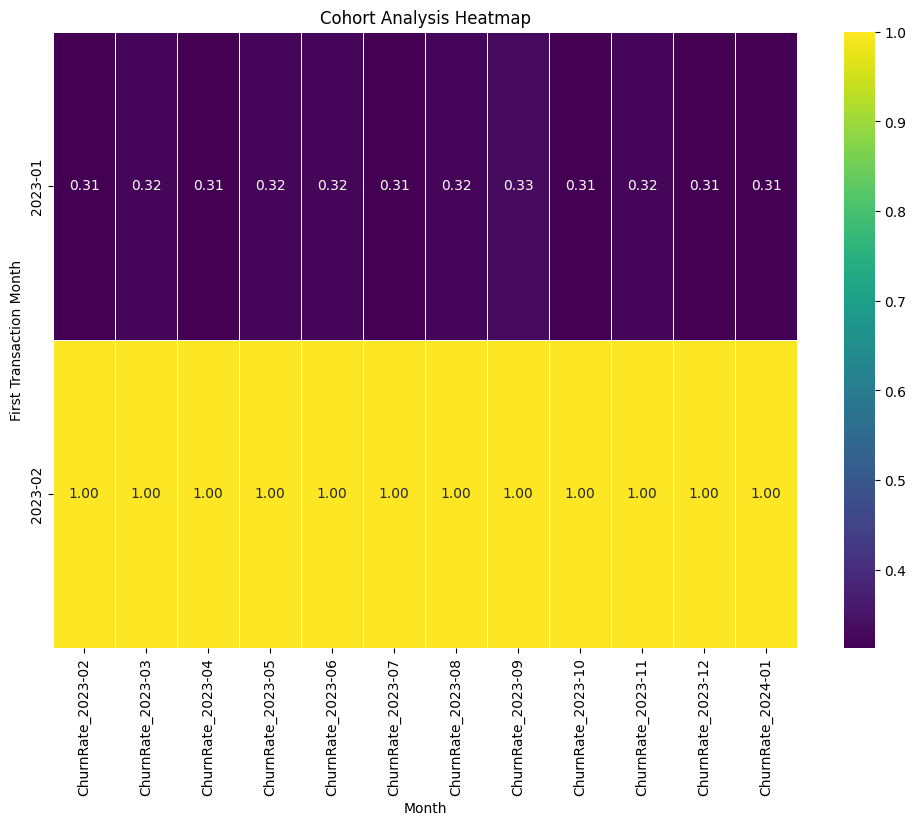

In [ ]:


#Apply heatmap styling to the cohort analysis DataFrame
def heatmap_color(val):
    """Convert numeric values to a color based on the viridis colormap."""
    color = plt.cm.viridis(val)  # Use 'viridis' colormap for heatmap
    return f'background-color: rgba{tuple(color[:3])}'

# Create a styled DataFrame with heatmap colors
styled_cohort_analysis = cohort_analysis.style.applymap(
    lambda x: heatmap_color(x),
    subset=[col for col in cohort_analysis.columns if col.startswith('ChurnRate_')]
)


plt.figure(figsize=(12, 8))
sns.heatmap(
    cohort_analysis.set_index('FirstTransactionMonth'),
    annot=True,
    cmap='viridis',
    cbar=True,
    linewidths=0.5,
    fmt='.2f'
)
plt.title('Cohort Analysis Heatmap')
plt.xlabel('Month')
plt.ylabel('First Transaction Month')
plt.show()

# Feature engineering (rule based)

In [ ]:
transaction_features = raw_transactions.groupby('CustomerID').agg({
    'TransactionAmount': ['sum', 'mean', 'count'],
    'TransactionDate': lambda x: (latest_date - x.max()).days
}).reset_index()
transaction_features.columns = ['CustomerID', 'TotalSpend', 'AvgTransactionAmount', 'TransactionFrequency', 'Recency']

In [ ]:
# Merge all relevant data including churn labels into a single DataFrame
merged_data = demographics.merge(customer_info, on='CustomerID')\
                          .merge(loans, on='CustomerID')\
                          .merge(transaction_features, on='CustomerID')\
                          .merge(churn_labels, on='CustomerID')

In [ ]:
# Loan-to-Income Ratio: ratio of loan amount to customer income
merged_data['LoanToIncomeRatio'] = merged_data['LoanAmount'] / merged_data['Income']

# Average Loan Amount (based on individual loans data)
merged_data['AvgLoanAmount'] = merged_data['LoanAmount']

# Account Tenure: convert account length from months to years
merged_data['AccountTenure'] = merged_data['AccountLength'] / 12

# Convert categorical variables to dummy/indicator variables
categorical_features = ['Gender', 'State', 'ContractType', 'ServicePlan', 'LoanStatus']
merged_data = pd.get_dummies(merged_data, columns=categorical_features, drop_first=True)

# Create datamart for modelling or analysis

In [ ]:
# Ensure 'LastTransactionDate' is not in merged_data
if 'LastTransactionDate' in merged_data.columns:
    merged_data = merged_data.drop(columns=['LastTransactionDate'])

# Drop the 'CustomerID' column
datamart = merged_data.drop(columns=['CustomerID'])

In [ ]:
datamart.head()

,Age,Income,AccountLength,CustServCalls,DaysSinceLastTransaction,LoanAmount,LoanTerm,InterestRate,TotalSpend,AvgTransactionAmount,...,State_FL,State_IL,State_NY,State_TX,ContractType_One year,ContractType_Two year,ServicePlan_Premium,ServicePlan_Standard,LoanStatus_Default,LoanStatus_Past Due
0,66,50455,110,7,1,46267.533112,24,3.246643,24878.352206,469.402872,...,False,False,False,False,False,True,True,False,False,False
1,30,101448,26,7,7,32318.092168,12,8.398619,24857.597915,478.030729,...,False,False,False,False,True,False,False,False,True,False
2,58,59974,214,9,7,41218.340009,36,3.574603,28930.958223,535.758486,...,True,False,False,False,False,False,False,True,False,False
3,44,57371,76,3,8,3891.163366,12,9.819979,27697.025291,543.078927,...,True,False,False,False,True,False,True,False,False,False
4,18,33936,32,5,1,45399.475821,36,3.594657,19718.221282,386.631790,...,True,False,False,False,False,True,False,True,False,False


In [ ]:
datamart.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 38 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Age                       100 non-null    int64  
 1   Income                    100 non-null    int64  
 2   AccountLength             100 non-null    int64  
 3   CustServCalls             100 non-null    int64  
 4   DaysSinceLastTransaction  100 non-null    int64  
 5   LoanAmount                100 non-null    float64
 6   LoanTerm                  100 non-null    int64  
 7   InterestRate              100 non-null    float64
 8   TotalSpend                100 non-null    float64
 9   AvgTransactionAmount      100 non-null    float64
 10  TransactionFrequency      100 non-null    int64  
 11  Recency                   100 non-null    int64  
 12  2023-02                   100 non-null    int64  
 13  2023-03                   100 non-null    int64  
 14  2023-04    

# Training Machine Learning Model (until December 2023)

In [ ]:
# Separate features and label for model training
X = datamart.drop(columns=[col for col in datamart.columns if col.startswith('2023-')])  # Use data up to December 2023
y = datamart[[col for col in datamart.columns if col.startswith('2023-')]].max(axis=1)  # Combine monthly churn labels to a single column, take maximum as worst case

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize the features to improve model performance
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Initialize and train a RandomForestClassifier model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [ ]:
pd.DataFrame(y)[0].value_counts(normalize = True)

,proportion
0,
0,0.61
1,0.39


In [ ]:
# Evaluate the model using the test set
y_pred = model.predict(X_test)

In [ ]:
print(confusion_matrix(y_test, y_pred))

[[18  0]
 [ 4  8]]


In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      1.00      0.90        18
           1       1.00      0.67      0.80        12

    accuracy                           0.87        30
   macro avg       0.91      0.83      0.85        30
weighted avg       0.89      0.87      0.86        30



# Predict for February 2024

In [ ]:
# Update dataset with data up to January 2024 for February 2024 prediction
prediction_date = pd.Timestamp('2024-02-01')

# Generate churn label for February 2024
churn_labels['2024-02'] = calculate_churn_for_month(
    customer_info, raw_transactions, loans, prediction_date
)

## Update features for prediction February 2024

In [ ]:
# Update transaction features to include data up to January 2024 (maximum = 31 January 2024, end of monthr)
transaction_features_jan = raw_transactions.groupby('CustomerID').agg({
    'TransactionAmount': ['sum', 'mean', 'count'],
    'TransactionDate': lambda x: (latest_date - x.max()).days
}).reset_index()
transaction_features_jan.columns = ['CustomerID', 'TotalSpend', 'AvgTransactionAmount', 'TransactionFrequency', 'Recency']

# Merge the new data with existing features up to January 2024
merged_data_jan = demographics.merge(customer_info, on='CustomerID')\
                          .merge(loans, on='CustomerID')\
                          .merge(transaction_features_jan, on='CustomerID')\
                          .merge(churn_labels[['CustomerID', '2024-02']], on='CustomerID')

# Feature Engineering
# Update features based on the new dataset
merged_data_jan['LoanToIncomeRatio'] = merged_data_jan['LoanAmount'] / merged_data_jan['Income']
merged_data_jan['AvgLoanAmount'] = merged_data_jan['LoanAmount']
merged_data_jan['AccountTenure'] = merged_data_jan['AccountLength'] / 12

# Convert categorical variables to dummy/indicator variables
merged_data_jan = pd.get_dummies(merged_data_jan, columns=categorical_features, drop_first=True)

# Ensure columns match with the model training data
missing_cols = set(X.columns) - set(merged_data_jan.columns)
for col in missing_cols:
    merged_data_jan[col] = 0
merged_data_jan = merged_data_jan[X.columns]

## Prediction

In [ ]:
# Predict churn for February 2024
X_feb = scaler.transform(merged_data_jan)
february_predictions = model.predict(X_feb)

results = pd.DataFrame({
    'CustomerID': demographics['CustomerID'],
    'ChurnPredictionFeb2024': february_predictions
})

In [ ]:
results

,CustomerID,ChurnPredictionFeb2024
0,0,0
1,1,1
2,2,0
3,3,0
4,4,0
...,...,...
95,95,1
96,96,0
97,97,0
98,98,0


In [ ]:
results.to_csv('chur_prediction_feb2024.csv', index = False)

## Workshop 06
1. หากต้องการกำหนดวันเริ่มต้นของการพิจารณาว่าไม่มีการใช้งานถือว่าย้ายค่ายเป็นวันใหม่ต้องกำหนดอย่างไร
2. หากต้องการกำหนดค่าการย้ายค่าย (y) เป็น 0.5  สำหรับลูกค้าที่หยุดใช้งานไปแล้วกลับมาใช้ใหม่และสถานะไม่มีการค้างชำระ จะต้องทำอย่างไร (คนที่ย้ายไปเลยให้เป็น 1 เหมือนเดิม)

(ตอบแต่ละข้อโดยการกำหนดที่ Code แล้วส่งเฉพาะ Code ส่วนที่เปลี่ยน)

In [ ]:
# กำหนดวันใหม่ใน function นี้โดยวันเริ่มต้นของการพิจารณาจะคำนวณจาก prediction_date - pd.DateOffset(days=lead_time_days)
# ซึ่งหมายความว่าวันเริ่มต้นจะเปลี่ยนแปลงตามตัวแปร lead_time_days โดยการเปลี่ยนแปลงค่านี้ต้องอาศัยการพูดคุยกับผู้เชี่ยวชาญด้วย

def calculate_churn_for_month(customer_info, raw_transactions, loans, prediction_date, lead_time_days=28):
    """
    Function to calculate churn labels for a specific month.
    A customer is labeled as churned if they have no transactions within the lead time period
    or if their loan status is 'Default'.
    """
    """
    ฟังก์ชันสำหรับคำนวณการสูญเสียลูกค้าในเดือนที่ระบุ
    ลูกค้าจะถูกจัดว่าสูญเสียในกรณีใดกรณีหนึ่งต่อไปนี้:
        1. ไม่มีการทำธุรกรรมใดๆ ในช่วงเวลาที่กำหนด
        2. สถานะเงินกู้ของลูกค้าอยู่ในสถานะ 'ผิดนัดชำระ'
    """
    # Define the window of time for which churn is being predicted
    start_date = prediction_date - pd.DateOffset(days=lead_time_days)
    end_date = prediction_date

    # Find recent transactions within the specified window
    recent_transactions = raw_transactions[
        (raw_transactions['TransactionDate'] >= start_date) &
        (raw_transactions['TransactionDate'] < end_date)
    ].groupby('CustomerID').size()

    # Determine churned customers: no transactions or loan in default
    churned_customers = customer_info['CustomerID'].apply(lambda x: 1 if (x not in recent_transactions.index) else 0)
    churned_customers = churned_customers | (loans.set_index('CustomerID')['LoanStatus'] == 'Default').astype(int)

    return churned_customers

In [ ]:
# จากโจทย์กำหนดให้ว่าหากย้ายค่ายแล้วกลับมาใช้งานให้เป็น 0.5 ซึ่งหมายความว่าหากค่าในคอลัมน์ที่เริ่มต้นด้วย '2023-'
# มีผลรวมมากกว่า 0 แต่ไม่ถึง 11 นั่นหมายความว่าลูกค้ามีการย้ายค่ายแล้วกลับมาใช้งานซึ่ง y=0.5
# แต่หากผลรวมแล้วได้ 11 หมายความว่าลูกค้าย้ายค่ายไปแล้ว y=1
# และหากผลผลรวมเป็น 0 หมายความว่าลูกค้าไม่ย้ายค่าย y=0

y = np.where(
    (datamart[[col for col in datamart.columns if col.startswith('2023-')]].sum(axis=1) > 0) &
    (datamart[[col for col in datamart.columns if col.startswith('2023-')]].sum(axis=1) < 11),
    0.5,
    np.where(
        (datamart[[col for col in datamart.columns if col.startswith('2023-')]].sum(axis=1) == 11),
        1,
        0
    )
)
y

array([0. , 1. , 0. , 0. , 0. , 1. , 0. , 0. , 1. , 0.5, 0. , 0. , 1. ,
       1. , 0. , 0. , 0. , 1. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 1. ,
       1. , 0. , 0. , 0. , 0.5, 1. , 0. , 1. , 0. , 0. , 1. , 0.5, 0. ,
       0. , 0. , 1. , 1. , 0. , 1. , 0. , 0. , 1. , 1. , 1. , 0. , 0.5,
       1. , 1. , 1. , 0. , 1. , 1. , 0. , 1. , 0. , 0. , 1. , 1. , 0. ,
       0. , 0. , 0. , 0. , 0.5, 0. , 0. , 0. , 0. , 0. , 0. , 1. , 0. ,
       0. , 0. , 0. , 0. , 1. , 0. , 0. , 1. , 1. , 0. , 0.5, 0. , 0. ,
       0. , 1. , 1. , 1. , 0.5, 0. , 0. , 0. , 0. ])